In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

In [6]:
import catboost

catboost.__version__

'1.2.5'

In [7]:
from catboost import datasets

train_df, test_df = datasets.amazon()
train_df.shape, test_df.shape

((32769, 10), (58921, 10))

In [11]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


MGR_ID : 현재 직원 ID 기록의 관리자의 직원 ID(한 직원이 한 번에 한 명의 관리자만 가질 수 있음).

Action : 리소스가 승인된 경우 ACTION은 1, 승인되지 않은 경우 0입니다.

ROLE_ROLLUP_1 : 회사 역할 그룹 카테고리 ID 1(예: 미국 엔지니어링)

ROLE_ROLLUP_2 : 회사 역할 그룹화 카테고리 ID 2(예: 미국 소매업)

ROLE_DEPTNAME : 회사 역할 부서 설명(예: 소매)

ROLE_TITLE : 회사 역할 비즈니스 직책 설명(예: 선임 엔지니어링 리테일 매니저)

ROLE_FAMILY_DESC : 회사 역할 패밀리 확장 설명(예: 소프트웨어 엔지니어링 리테일 매니저)

ROLE_FAMILY : 회사 역할군 설명(예: 리테일 매니저)

ROLE_CODE : 회사 역할 코드; 이 코드는 각 역할에 고유합니다(예: 관리자).

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [15]:
y = train_df['ACTION']
X = train_df.drop(columns='ACTION')

x_test = test_df.drop(columns='id')

In [16]:
SEED = 1

In [18]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=SEED)

In [22]:
from catboost import CatBoostClassifier

params = {
    'loss_function': 'Logloss', # objective function
    'eval_metric' : 'AUC', # metric
    'verbose' : 200, # output to stdout info about training process every 200 iterations
    'random_seed': SEED,
}
cbc_1 = CatBoostClassifier(**params)

cbc_1.fit(x_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(x_val, y_val), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=False) # True for visualization of the training process (it is not shown in a published kernel - try executing this code)

Learning rate set to 0.069882
0:	test: 0.5400959	best: 0.5400959 (0)	total: 11ms	remaining: 11s
200:	test: 0.8020842	best: 0.8020842 (200)	total: 1.6s	remaining: 6.38s
400:	test: 0.8237941	best: 0.8237941 (400)	total: 3.17s	remaining: 4.73s
600:	test: 0.8328464	best: 0.8330283 (598)	total: 4.69s	remaining: 3.11s
800:	test: 0.8366271	best: 0.8370599 (785)	total: 6.29s	remaining: 1.56s
999:	test: 0.8417823	best: 0.8417823 (999)	total: 7.85s	remaining: 0us

bestTest = 0.8417823185
bestIteration = 999



겨우 84퍼의 성공률을 보입니다. 더 많은 iteration을 반복하면 더 나은 결과를 보여줄 수 있습니다.<br/>
그렇다면 어떻게하면 결과를 개선할 수 있을까요?<br/>
우선 어떤 피처에을 범주형으로 지정해야 합니다. 위의 모델에서 Catboost는 범주형 features를 숫자로 처리했습니다. 따라서 category의 순위가 매겨졌습니다.

In [25]:
X.shape

(32769, 9)

In [23]:
cat_features = list(range(X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [26]:
cat_features_names = X.columns
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [27]:
condition = True # here we specify what condition should be satisfied only by the names of categorical features
cat_features_names = [col for col in X.columns if condition]
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [29]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features, # 위의 params와 차이점 !
          'verbose': 200,
          'random_seed': SEED
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(x_train, y_train,
          eval_set=(x_val, y_val),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 64.9ms	remaining: 1m 4s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 13s	remaining: 51.8s
400:	test: 0.8985289	best: 0.8990341 (378)	total: 27.7s	remaining: 41.4s
600:	test: 0.9005314	best: 0.9006239 (594)	total: 42.8s	remaining: 28.4s
800:	test: 0.9003244	best: 0.9013196 (668)	total: 58.3s	remaining: 14.5s
999:	test: 0.8991045	best: 0.9013196 (668)	total: 1m 13s	remaining: 0us

bestTest = 0.901319646
bestIteration = 668

Shrink model to first 669 iterations.
CPU times: total: 34.8 s
Wall time: 1min 14s


### ↑ cat_features를 추가한 결과

더 많은 시간이 걸리긴 했지만 훨씬 더 빠르게 최상의 결과를 얻었음. <br/>
이 문제는 early_stopping_rounds=N 으로 지정하여 처리할 수 있음. 즉 N 라운드동안 metrics의 결과가 개선되지 않으면 모델이 훈련을 중단함.

In [31]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(x_train, y_train, 
          eval_set=(x_val, y_val), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 60.7ms	remaining: 1m
200:	test: 0.8959353	best: 0.8959406 (199)	total: 14.8s	remaining: 58.7s
400:	test: 0.8985289	best: 0.8990341 (378)	total: 30.9s	remaining: 46.2s
600:	test: 0.9005314	best: 0.9006239 (594)	total: 46.7s	remaining: 31s
800:	test: 0.9003244	best: 0.9013196 (668)	total: 1m 2s	remaining: 15.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.901319646
bestIteration = 668

Shrink model to first 669 iterations.
CPU times: total: 29.1 s
Wall time: 1min 8s


dnldml rufrhkrk

In [32]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [34]:
np.random.seed(SEED)
noise_cols = [f'noise_{i}' for i in range(5)]
noise_cols

for col in noise_cols:
    x_train[col] = y_train * np.random.rand(x_train.shape[0])
    x_val[col] = np.random.rand(x_val.shape[0])

In [35]:
x_train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,noise_0,noise_1,noise_2,noise_3,noise_4
16773,27798,1350,117961,118052,122938,117905,117906,290919,117908,0.417022,0.097850,0.665600,0.979025,0.491624
23491,80701,4571,117961,118225,119924,118685,279443,308574,118687,0.720324,0.855900,0.311763,0.929346,0.391708
32731,34039,5113,117961,118300,119890,119433,133686,118424,119435,0.000114,0.287838,0.896624,0.704050,0.606467
7855,42085,4733,118290,118291,120126,118980,166203,118295,118982,0.302333,0.264320,0.482195,0.028493,0.182570
16475,16358,6046,117961,118446,120317,307024,306404,118331,118332,0.146756,0.022876,0.009307,0.726750,0.623357


In [37]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_5 = CatBoostClassifier(**params)
cbc_5.fit(x_train, y_train, 
          eval_set=(x_val, y_val), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.4990944	best: 0.4990944 (0)	total: 43.1ms	remaining: 43s
200:	test: 0.5831370	best: 0.5894476 (7)	total: 12.8s	remaining: 51s
400:	test: 0.5831376	best: 0.5894476 (7)	total: 25.5s	remaining: 38.1s
600:	test: 0.5831376	best: 0.5894476 (7)	total: 38.4s	remaining: 25.5s
800:	test: 0.5831384	best: 0.5894476 (7)	total: 50.5s	remaining: 12.6s
999:	test: 0.5831381	best: 0.5894476 (7)	total: 1m 2s	remaining: 0us

bestTest = 0.5894475816
bestIteration = 7

Shrink model to first 8 iterations.


Wow, didn't expect it to be that low. Let's specify columns which we want to ignore:

In [39]:
ignored_features = list(range(x_train.shape[1] - 5, x_train.shape[1]))
print(ignored_features)

[9, 10, 11, 12, 13]


In [41]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'ignored_features': ignored_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_6 = CatBoostClassifier(**params)
cbc_6.fit(x_train, y_train, 
          eval_set=(x_val, y_val), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 84.7ms	remaining: 1m 24s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 19.4s	remaining: 1m 17s
400:	test: 0.8985289	best: 0.8990341 (378)	total: 39.8s	remaining: 59.5s
600:	test: 0.9005314	best: 0.9006239 (594)	total: 1m	remaining: 40.1s
800:	test: 0.9003244	best: 0.9013196 (668)	total: 1m 21s	remaining: 20.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.901319646
bestIteration = 668

Shrink model to first 669 iterations.


In [54]:
x_train = x_train.drop(columns=noise_cols)
x_val = x_val.drop(columns=noise_cols)

In [56]:
x_train.head()

x_val.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
11504,42006,85475,117961,118300,123472,117905,117906,290919,117908
6966,44724,25329,118212,119763,123173,119849,263199,118638,119851
20262,44731,25686,118541,118542,118562,126138,191718,124136,126140
7815,34542,7807,117961,118327,118518,120097,124862,270488,120099
28682,33054,131441,117961,118343,118292,118422,300136,118424,118425


In [57]:
from catboost import Pool


train_data = Pool(data=x_train, label=y_train, cat_features=cat_features)
valid_data = Pool(data=x_val, label=y_val, cat_features=cat_features)

In [58]:
params = {
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'early_stopping_rounds': 200,
    'verbose': 200,
    'random_seed': SEED
}

cbc_7 = CatBoostClassifier(**params)
cbc_7.fit(train_data, eval_set=valid_data, use_best_model=True, plot=False)

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 97.9ms	remaining: 1m 37s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 21.9s	remaining: 1m 26s
400:	test: 0.8985289	best: 0.8990341 (378)	total: 44s	remaining: 1m 5s
600:	test: 0.9005314	best: 0.9006239 (594)	total: 1m 5s	remaining: 43.7s
800:	test: 0.9003244	best: 0.9013196 (668)	total: 1m 27s	remaining: 21.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.901319646
bestIteration = 668

Shrink model to first 669 iterations.


보시다시피 cbc_2와 동일한 결과를 얻었습니다. 그렇다면 왜 풀 객체를 만들어야 할까요? <br/>
풀 객체에는 몇 가지 좋은 메서드가 있습니다. <br/>
예를 들어, 데이터의 일부가 오래되어 부정확할 수 있습니다. Pool.set_weight()를 사용하면 데이터의 인스턴스(행)에 가중치를 지정할 수 있습니다. 또는 Pool.set_group_id()를 사용해 데이터를 그룹으로 나누고, Pool.set_group_weight()를 사용해 그룹마다 다른 가중치를 적용할 수 있습니다. 기준선이 계산될 수 있습니다. 그런 다음 Pool.set_baseline()을 사용하여 모든 입력 개체에 대한 초기 수식 값을 제공할 수 있습니다. 따라서 훈련은 0에서 시작하는 대신 모든 입력 객체에 대해 이 값에서 시작됩니다.

마지막으로, 풀 객체는 데이터의 경계가 있는 부분을 포함할 수 있는 좋은 방법이기도 합니다. <br/>

Translated with www.DeepL.com/Translator (free version)

In [59]:
from catboost import cv

In [60]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED
         }

all_train_data = Pool(data=X,
                      label=y,
                      cat_features=cat_features
                     )

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=4,
            seed=SEED, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 73.3ms	remaining: 1m 13s
200:	test: 0.8938231	best: 0.8938231 (200)	total: 22.5s	remaining: 1m 29s
400:	test: 0.8976768	best: 0.8976768 (400)	total: 48.9s	remaining: 1m 13s
600:	test: 0.9016370	best: 0.9016602 (599)	total: 1m 14s	remaining: 49.6s
800:	test: 0.9027846	best: 0.9027909 (799)	total: 1m 40s	remaining: 25s
999:	test: 0.9035137	best: 0.9035137 (999)	total: 2m 6s	remaining: 0us

bestTest = 0.9035137273
bestIteration = 999

Training on fold [1/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 64.4ms	remaining: 1m 4s
200:	test: 0.8827467	best: 0.8832037 (146)	total: 22.4s	remaining: 1m 29s
400:	test: 0.8844741	best: 0.8844968 (397)	total: 48.4s	remaining: 1m 12s
600:	test: 0.8860410	best: 0.8864452 (506)	total: 1m 14s	remaining: 49.6s
800:	test: 0.8864595	best: 0.8864742 (799)	total: 1m 40s	remaining: 25s
999:	test: 0.8850072	best: 0.8864950 (822)	total: 2m 5s	remaining: 0us

bestTest = 0.8864949928
bestIteratio

In [65]:
cbc_7.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,19.217358
1,ROLE_DEPTNAME,16.097968
2,MGR_ID,14.650751
3,ROLE_ROLLUP_2,13.982474
4,ROLE_FAMILY_DESC,9.284954
5,ROLE_TITLE,7.457760
6,ROLE_FAMILY,6.640972
7,ROLE_ROLLUP_1,6.520056
8,ROLE_CODE,6.147706


In [64]:
import pandas as pd

feature_importance_df = pd.DataFrame(cbc_7.get_feature_importance(prettified=True), columns=['Feature Id', 'Importances'])

feature_importance_df

,Feature Id,Importances
0,RESOURCE,19.217358
1,ROLE_DEPTNAME,16.097968
2,MGR_ID,14.650751
3,ROLE_ROLLUP_2,13.982474
4,ROLE_FAMILY_DESC,9.284954
5,ROLE_TITLE,7.457760
6,ROLE_FAMILY,6.640972
7,ROLE_ROLLUP_1,6.520056
8,ROLE_CODE,6.147706


Text(0.5, 1.0, 'Catboost features importance')

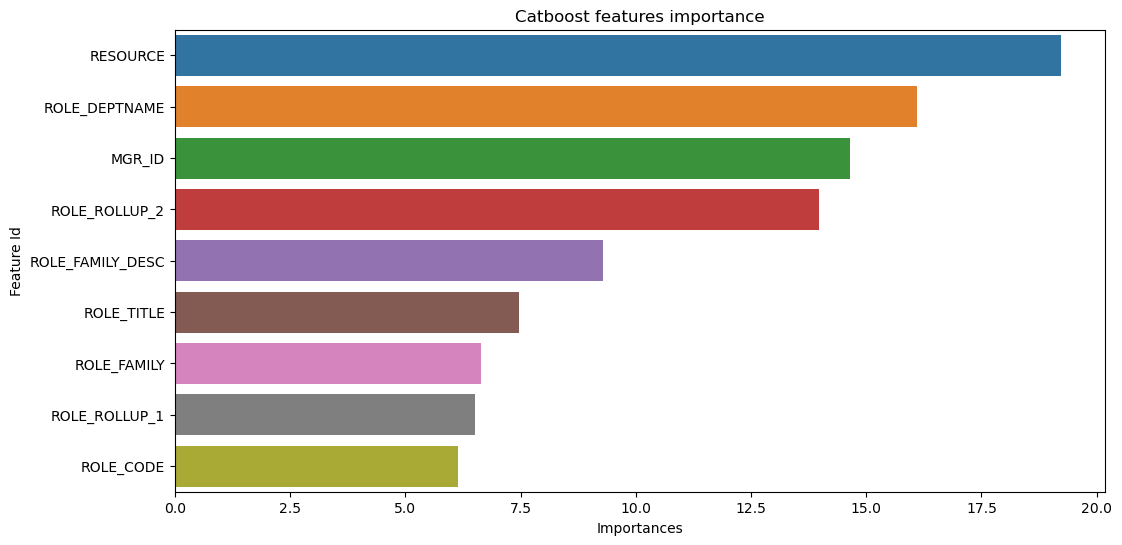

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df)
plt.title("Catboost features importance")

In [70]:
import shap
explainer = shap.TreeExplainer(cbc_7) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], x_train.iloc[:100,:])

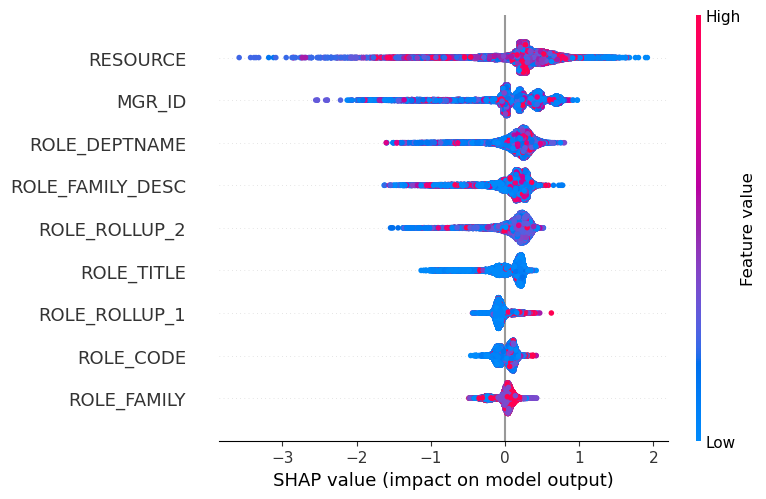

In [72]:
shap.summary_plot(shap_values, x_train)